실습예제

In [ ]:
#사인곡선

In [ ]:
import numpy as np
# arrange(start,stop,step)
a=np.arange(0,10,0.5) #0~10까지 0.5 간격으로 값을 생성
data=np.sin(a)
print(a)
print(data)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(data)

In [ ]:
timestep=3 #t-3,t-2,t-1 데이터로 t시점으 ㅣ값을 구하고자 함
X,y=[],[]
for i in range(timestep, len(data)):
    print(i)
    X.append(np.array([data[i-j] for j in range(timestep,0,-1)] ))
    y.append(data[i])

print(X[0])
print(X[1])
print(X[2])
print(X[3])
#print(y)

In [ ]:
#신경망에 입력하기 위하여 차원 변경 , 신경망에 입력할려면 2차원으로 변경해야함
X,y=np.array(X).reshape(len(X),3,1), np.array(y).reshape(len(y),1)

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense

np.random.seed(0) #랜덤시드 고정

model=Sequential()
# 단순한 순환신경망, units 출력노드수 input_shape 입력데이터의 형태
model.add(SimpleRNN(units=10, input_shape=(3,1)))
model.add(Dense(5, activation='relu'))
# 출력층, 출력노드 1개, 활성화함수 linear 값 자체를 예측하고자 할 때
model.add(Dense(1, activation='linear'))
model.compile(loss='mse',optimizer='sgd')
model.summary()

In [ ]:
hist=model.fit(X,y,epochs=1000,verbose=1) #학습

In [ ]:
print(data[3:])
print(model.predict(X))
plt.plot(data[3:],'ro-',label='real value') #실제값
plt.plot(model.predict(X), 'bo-',label='predict value') #예측값
plt.legend()
plt.show()

In [ ]:
#단어예측

In [ ]:
text="""
경마장에 있는 말이 뛰고 있다 \n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n
그런 식으로 하면 말이 안된다\n
새로 태어난 말이 배가 고프다\n
우리 집 말이 배가 고파요\n
"""

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
t=Tokenizer() #단어 집합을 만들고 숫자 인덱스 부여
t.fit_on_texts([text])
vocab_size=len(t.word_index)+1 #단어 집합의 크기
print(vocab_size)
print(t.word_index)

In [ ]:
sequences=list()
for line in text.split('\n'): #문장을 나눔
    #단어의 인덱스로만 구성된 새로운 리스트
    encoded=t.texts_to_sequences([line])[0]
    for i in range(1,len(encoded)):
        sequence=encoded[:i+1]
        sequences.append(sequence)
        
print('샘플 갯수:',len(sequences))
print(sequences)

In [ ]:
max_len=max(len(l) for l in sequences)
print(max_len) #샘플의 최대 길이

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#샘플의 최대 길이에 맞추는 과정
sequences=pad_sequences(sequences, maxlen= max_len, padding='pre')
print(sequences)

In [ ]:
import numpy as np
sequences=np.array(sequences)
X=sequences[:,:-1] #독립변수
y=sequences[:,-1] #종속변수
print(X)
print(y)

In [ ]:
a=[[1,2,3],[4,5],[6,7,8,9]]
print(a)
print(pad_sequences(a))#최대 사이즈에 맞추어 왼쪽에 0이 채워짐
print(pad_sequences(a,padding='post')) #오른쪽에 0이 채워짐
print(pad_sequences(a,padding='post',value=1)) #1을 채움
print(pad_sequences(a,padding='post',maxlen=3)) #최대 사이즈 설정
#실제크기보다 최대 사이즈가 작을 경우 오른쪽을 삭제
print(pad_sequences(a,padding='post',maxlen=3,truncating='post'))

In [ ]:
import numpy as np
sequences=np.array(sequences)
X=sequences[:, :-1] #독립변수
y=sequences[:,-1] #종속변수
print(X)
print(y)

In [ ]:
from keras.utils import np_utils
#출력값에 대한 원핫인코딩
y=np_utils.to_categorical(y, num_classes=vocab_size)
print(y.shape)
print(y)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Embedding,SimpleRNN

model=Sequential()
#Embedding(단어갯수, 벡터크기, 입력사이즈)
model.add(Embedding(vocab_size,10,input_length=max_len-1))
model.add(SimpleRNN(32))
#출력노드
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

In [ ]:
words={'I':0,'am':1,'a':2,'boy':3}
print(words.items())
embeddings=model.layers[0].get_weights()[0]
words_embeddings={w:embeddings[idx] for w,idx in words.items()}
print(words_embeddings)
print(words_embeddings['boy'])

In [ ]:
model.fit(X,y,epochs=200,verbose=2)

In [ ]:
def sentence_generation(model,t,current_word,n):
    init_word=current_word
    sentence=''
    for _ in range(n):
        #현재 단어데 대한 정수 인코딩
        encoded=t.texts_to_sequences([current_word])[0]
        #사이즈를 맞추기 위한 패딩 처리
        encoded=pad_sequences([encoded],maxlen=max_len-1,
                             padding='pre')
        #입력값으로 단어를 예측하고
        result=model.predict_classes(encoded,verbose=0)
        for word,index in t.word_index.items():
            #같은 단어이면
            if index==result:
                break
        #현재 단어에 연결
        current_word=current_word + ' ' + word
        #문장에 추가
        sentence = sentence + ' ' + word
    sentence= init_word + sentence
    return sentence

In [ ]:
print(sentence_generation(model, t, '경마장에',4))
print(sentence_generation(model, t, '그의',2))
print(sentence_generation(model, t, '가는',5))
print(sentence_generation(model, t, '그런',4))
print(sentence_generation(model, t, '새로',4))
print(sentence_generation(model, t, '우리',4))

In [ ]:
#주가예측

In [ ]:
import pandas as pd

df=pd.read_csv('d:/data/time/data2.csv')
df.head()

In [ ]:
df.info()

In [ ]:
%matplotlib inline
from pandas.tseries.offsets import MonthEnd
#날짜 필드를 날짜형으로 바꾸고 해당 월의 마지막날짜로 지정
df['date']=pd.to_datetime(df['date'])+MonthEnd(1)
print(df['date'])
#날짜를 row index로 지정
df=df.set_index('date')
print(df)
df.plot()

In [ ]:
import matplotlib.pyplot as plt
#기준일자 지정
split_data=pd.Timestamp('01-01-2011') #2011년 1월 1일 기준
train=df.loc[:split_data, ['price']] #학습용
test=df.loc[split_data:,['price']] #검증용
ax=train.plot()
test.plot(ax=ax)
plt.legend(['train','test'])

In [ ]:
#0~1 정규화
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
sc.fit(train) #학습
train_sc = sc.transform(train) #변환
test_sc = sc.transform(test)

#train_sc
print(train['price'][:10])
print(train_sc[:10])

In [ ]:
#넘파이배열을 데이터프레임으로 변환
train_sc_df=pd.DataFrame(train_sc, columns=['Scaled'],
                        index=train.index)
test_sc_df=pd.DataFrame(test_sc, columns=['Scaled'],
                       index=test.index)
train_sc_df.head()

In [ ]:
s=pd.Series([100,200,300,400,500,600,700,800,900,1000])
# s2=s.shift(1) #오른쪽으로 1쉬프트 시킴
# s3=s.shift(2) #오른쪽으로 2쉬프트 시킴
# s4=s.shift(3) #오른쪽으로 3쉬프트 시킴
s2=s.shift(-1) #왼쪽으로 1쉬프트 시킴
s3=s.shift(-2) #왼쪽으로 2쉬프트 시킴
s4=s.shift(-3) #왼쪽으로 3쉬프트 시킴
print(s.values)
print(s2.values)
print(s3.values)
print(s4.values)

In [ ]:
#timestep을 12로 설정하여 쉬프트시킨 데이터
for s in range(1,13):
    train_sc_df['shift_{}'.format(s)]=train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)]=test_sc_df['Scaled'].shift(s)

In [ ]:
train_sc_df.head()

In [ ]:
#NAN 제거
X_train=train_sc_df.dropna().drop('Scaled',axis=1)
y_train=train_sc_df.dropna()[['Scaled']]
X_test=test_sc_df.dropna().drop('Scaled',axis=1)
y_test=test_sc_df.dropna()[['Scaled']]

X_train.head()

In [ ]:
#넘파이배열로 저장
X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values
print(X_train.shape)

In [ ]:
#신경망에 입력하기 위하여 3차원 데이터로 변환
X_train_t=X_train.reshape(X_train.shape[0],12,1)
X_test_t=X_test.reshape(X_test.shape[0],12,1)

In [ ]:
#신경망 모형
from keras.layers import LSTM,Dense
from keras.models import Sequential
model=Sequential()
#Long Short Term Momory, RNN 모형의 일종
#input_shape=(timestep,변수갯수)
model.add(LSTM(20, input_shape=(12,1)))
model.add(Dense(1)) #출력층, 노드수 1개
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

In [ ]:
#학습과정
model.fit(X_train_t,y_train, epochs=250, batch_size=30, verbose=1)

In [ ]:
y_pred=model.predict(X_test_t)
print(y_pred.flatten()[:10])#예측값
print(y_test.flatten()[:10])#실제값

In [ ]:
#실제값 - 예측값의 평균
import numpy as np
np.mean(y_test.flatten() - y_pred.flatten())

In [ ]:
#실제값과 예측값의 비교 그래프
plt.plot(y_test.flatten(), 'ro-',label='real value')
plt.plot(y_pred.flatten(), 'bo-',label='predict value')
plt.legend()
plt.show()

In [ ]:
# imdb 영화리뷰 분류

In [ ]:
import numpy as np
from keras.datasets import imdb
from keras.preprocessing import sequence


np.random.seed(7) #랜덤 시드 고정

top_words=5000 #상위 단어 5000개 선택
#영화리뷰 데이터를 다운로드한 후 학습용, 검증용으로 구분

(X_train,y_train),(X_test,y_test)=imdb.load_data(num_words=top_words)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
for row in X_train[:50]:
    print(len(row),end=' ')

In [ ]:
max_review_length=500 #리뷰의 최대 길이를 설정
#패딩을 추가하여 길이를 맞춤
X_train=sequence.pad_sequences(X_train,maxlen=max_review_length)
X_test=sequence.pad_sequences(X_test,maxlen=max_review_length)
print(X_train.shape)
print(X_test.shape)

In [ ]:
for row in X_train[:50]:
    print(len(row),end=' ')

In [ ]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense,LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D

embedding_vector_length=32 #벡터사이즈
model=Sequential()
# Embedding(단어의갯수, 벡터크기,입력사이즈)
model.add(Embedding(top_words,embedding_vector_length,
                   input_length=max_review_length))
#filters 필터 갯수, kernel_size 필터의 사이즈
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100)) #타임스텝을 100으로 설정한 순환 레이어
model.add(Dense(1, activation='sigmoid')) #출력층
model.compile(loss='binary_crossentropy',optimizer='adam',
             metrics=['accuracy'])
model.summary()

In [ ]:
#학습과정
hist=model.fit(X_train[:1000],y_train[:1000],epochs=10,
              batch_size=64,validation_split=0.2)

In [ ]:
#모형평가
scores=model.evaluate(X_train[:1000],y_train[:1000],verbose=1)
print(scores)
scores=model.evaluate(X_test[:1000],y_test[:1000],verbose=1)
print(scores)

In [ ]:
#학습과정 그래프
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','accuracy','val_loss','val_accuracy'])
plt.grid()
plt.show()

In [ ]:
#로이터 뉴스 분류

In [ ]:
from keras.datasets import reuters
#로이터 뉴스 데이터셋 다운로드
#학습용 검증용 8:2로 구분, 뉴스별 최대 단어 갯수 100개로 설정
(X_train, y_train),(X_test,y_test) = reuters.load_data(
num_words=1000,test_split=0.2)

In [ ]:
for x in X_train[:50]:
    print(len(x),end=' ')
    
print(X_train[10])

In [ ]:
from keras.preprocessing import sequence
#가로 길이 50으로 설정하여 사이즈를 맞춤(공백은 0으로 채움)
X_train=sequence.pad_sequences(X_train,maxlen=50)
X_test=sequence.pad_sequences(X_test,maxlen=50)

In [ ]:
for x in X_train[:50]:
    print(len(x),end=' ')
    
print(X_train[10])

In [ ]:
for i in range(50):
    print(y_train[i], end=' ')

In [ ]:
from keras.utils import np_utils
# 뉴스 카테고리 46개, 원핫인코딩
y_train=np_utils.to_categorical(y_train)
y_test=np_utils.to_categorical(y_test)

In [ ]:
for i in range(3):
    print(y_train[i], end=' ')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding
model=Sequential()
#임베딩 레이어, Embedding(단어갯수, 벡터사이즈, 입력사이즈)
model.add(Embedding(1000,100,input_length=50))
model.add(LSTM(100)) #타임스텝을 100으로 설정
model.add(Dense(46,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',
             metrics=['accuracy'])
model.summary()

In [ ]:
hist=model.fit(X_train,y_train,batch_size=100,epochs=20,
              validation_split=0.2)

In [ ]:
print(model.evaluate(X_train,y_train))
print(model.evaluate(X_test,y_test))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.show()

In [ ]:
#스팸메일 분류

In [ ]:
import pandas as pd
df=pd.read_csv('d:/data/spam/spam.csv', encoding='latin1')
df.head()

In [ ]:
# ham=>0 spam=>1로 저장
df['v1']=df['v1'].replace(['ham','spam'],[0,1])
df.head()

In [ ]:
df.shape

In [ ]:
%matplotlib inline
print(df['v1'].value_counts())
df['v1'].value_counts().plot(kind='bar')

In [ ]:
X=df[['v2']] #독립변수
y=df[['v1']] #종속변수

In [ ]:
#언더샘플링
from imblearn.under_sampling import RandomUnderSampler
X_sample,y_sample=RandomUnderSampler(random_state=0).fit_sample(X,y)
X_samp=pd.DataFrame(data=X_sample,columns=['v2'])
y_samp=pd.DataFrame(data=y_sample,columns=['v1'])
df_samp=pd.concat([X_samp,y_samp],axis=1)

In [ ]:
print(df_samp['v1'].value_counts())
df_samp['v1'].value_counts().plot(kind='bar')

In [ ]:
X=df_samp['v2']
y=df_samp['v1']

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
# 단어집합을 만들고 단어마다 고유한 숫자 인덱스 부여
tokenizer.fit_on_texts(X)
# 단어의 숫자 인덱스로만 구성된 새로운 리스트로 변환
sequences=tokenizer.texts_to_sequences(X)
#print(sequences[:5])
print(X[0])
print(sequences[0])

In [ ]:
#단어와 인덱스 목록
word_to_index=tokenizer.word_index
print(word_to_index)

In [ ]:
[len(l) for l in X_data]

In [ ]:
max(len(l) for l in X_data)

In [ ]:
list(map(len,X_data)) #전체 갯수

In [ ]:
import matplotlib.pyplot as plt
X_data=sequences
print('메일의 최대 길이:',max(len(l) for l in X_data))
print('메일의 평균 길이:',(sum(map(len,X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('lenght of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#최대 사이즈 77에 맞추어 패딩 처리(가로 사이즈를 맞추는 작업)
data=pad_sequences(X_data,maxlen=77)

In [ ]:
#학습용:검증용 8:2로 구분
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data,y,test_size=0.2,stratify=y,random_state=10)

In [ ]:
#신경망 모형
from tensorflow.keras.layers import Embedding,Dense,LSTM,SimpleRNN
from tensorflow.keras.models import Sequential
model=Sequential()
# Embdeeing(입력사이즈,출력사이즈)
model.add(Embedding(len(word_to_index)+1,32)) #입력층
model.add(SimpleRNN(32)) #순환층
#model.add(LSTM(32)) #타임스텝을 32로 설정
model.add(Dense(1, activation='sigmoid')) #출력층
model.compile(optimizer='rmsprop',loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

In [ ]:
hist=model.fit(X_train,y_train.values, epochs=10,
              batch_size=64, validation_split=0.2)

In [ ]:
model.evaluate(X_test, y_test.values, verbose=0)

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.show()

In [ ]:
#한글 텍스트 분류

In [1]:
import pandas as pd
df=pd.read_csv('d:/data/text/ratings_all.csv',encoding='ms949')
df.head()

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


1    100000
0    100000
Name: label, dtype: int64


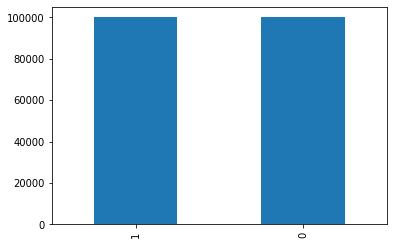

In [2]:
%matplotlib inline
print(df['label'].value_counts())
df['label'].value_counts().plot(kind='bar')

In [3]:
import re
text='I am a boy.#,:;!$!나는 소년이다.'
print(text)
#정규표현식
# [^] not
print(re.sub('[^a-zA-Z ]','',text)) #영문자,공백만 허용
print(re.sub('[^ㄱ-하-ㅣ가-힣]','',text)) #한글,공백만 허용


I am a boy.#,:;!$!나는 소년이다.
I am a boy 
나는소년이다


In [4]:
df['document']=df['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
df['document']

0                                         아 더빙 진짜 짜증나네요 목소리
1                                흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
                                ...                        
199995            오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함
199996             의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 
199997                      그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다
199998           절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네
199999                                           마무리는 또 왜이래
Name: document, Length: 200000, dtype: object

In [5]:
import numpy as np
# '' 빈문자열을 np.nan으로 바꾸고 기존 데이터프레임 내용을 변경시킴
df['document'].replace('',np.nan,inplace=True)

In [6]:
df.loc[df.document.isnull()][:5] #결측값 확인

,document,label
584,NaN,0
593,NaN,0
638,NaN,0
668,NaN,0
1058,NaN,0


In [7]:
df=df.dropna(how='any') #결측값이 있는 행을 제거함

In [8]:
df.info

<bound method DataFrame.info of                                                  document  label
0                                       아 더빙 진짜 짜증나네요 목소리      0
1                              흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나      1
2                                       너무재밓었다그래서보는것을추천한다      0
3                               교도소 이야기구먼 솔직히 재미는 없다평점 조정      0
4       사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...      1
...                                                   ...    ...
199995          오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함      1
199996           의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따       0
199997                    그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다      0
199998         절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네      0
199999                                         마무리는 또 왜이래      0

[198884 rows x 2 columns]>

In [9]:
X=df[['document']] #독립변수
y=df['label'] #종속변수

In [10]:
df['label'].value_counts()

1    99510
0    99374
Name: label, dtype: int64

In [11]:
#언더샘플링
from imblearn.under_sampling import RandomUnderSampler
X_sample,y_sample=RandomUnderSampler(random_state=0).fit_sample(X,y)
X_samp=pd.DataFrame(data=X_sample, columns=['documnet'])
y_samp=pd.DataFrame(data=y_sample, columns=['label'])
df_samp=pd.concat([X_samp,y_samp],axis=1)

Using TensorFlow backend.


In [12]:
df_samp['label'].value_counts()

1    99374
0    99374
Name: label, dtype: int64

In [13]:
#불용어 사전
stopwords=['의','가','이','은','들','을','는','좀','잘','걍','과',
          '도','를','으로','자','에','와','한','하다','이다','였다']

In [14]:
from konlpy.tag import Okt
okt=Okt()
okt.morphs('나는 집에 간다',stem=True) #형태소 분석

['나', '는', '집', '에', '간다']

In [15]:
X=[]
y=[]
print(df['document'][100])
for idx,sentence in enumerate(df['document'][:1000]):
    temp=[]
    temp=okt.morphs(sentence,stem=True) #문장을 토큰화
    #불용어를 제거한 후
    temp=[word for word in temp if not word in stopwords]
    X.append(temp) #리뷰 내용(단어들)을 추가
    y.append(df.iloc[idx,1]) #0,1
print(X[100])

신카이 마코토의 작화와미유와 하나카나가 연기를 잘해줘서 더대박이였다
['신카이', '마코토', '작화', '밉다', '유', '하나', '카나', '연기', '해주다', '더', '대박']


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()
#단어 집합을 만들고 단어에 고유한 숫자 인덱스 부여
tokenizer.fit_on_texts(X)

In [17]:
tokenizer.word_index

{'영화': 1,
 '보다': 2,
 '없다': 3,
 '있다': 4,
 '좋다': 5,
 '다': 6,
 '적': 7,
 '진짜': 8,
 '정말': 9,
 '너무': 10,
 '아니다': 11,
 '재밌다': 12,
 '만': 13,
 '되다': 14,
 '같다': 15,
 '연기': 16,
 '인': 17,
 '로': 18,
 '나오다': 19,
 '최고': 20,
 '점': 21,
 '안': 22,
 '에서': 23,
 '사람': 24,
 '내': 25,
 '않다': 26,
 '보고': 27,
 '그': 28,
 '만들다': 29,
 '것': 30,
 '왜': 31,
 '못': 32,
 '하고': 33,
 '나': 34,
 '감동': 35,
 '말': 36,
 '재미': 37,
 '아깝다': 38,
 '고': 39,
 '재미없다': 40,
 '싶다': 41,
 'ㅋㅋ': 42,
 '재미있다': 43,
 '생각': 44,
 '내용': 45,
 '배우': 46,
 '더': 47,
 '아': 48,
 '그냥': 49,
 '드라마': 50,
 '중': 51,
 '시간': 52,
 '평점': 53,
 '때': 54,
 '스토리': 55,
 '들다': 56,
 '감독': 57,
 '알다': 58,
 '쓰레기': 59,
 '하나': 60,
 '게': 61,
 '그렇다': 62,
 '작품': 63,
 '볼': 64,
 'ㅠㅠ': 65,
 '자다': 66,
 '완전': 67,
 '요': 68,
 '모르다': 69,
 '또': 70,
 '주인공': 71,
 '개': 72,
 '기': 73,
 '지루하다': 74,
 '정도': 75,
 '주다': 76,
 '느낌': 77,
 '거': 78,
 '년': 79,
 '네': 80,
 '듯': 81,
 '오다': 82,
 'ㅋㅋㅋ': 83,
 '돈': 84,
 '가다': 85,
 '지': 86,
 '수': 87,
 '다시': 88,
 '일': 89,
 '뭐': 90,
 '먹다': 91,
 '이건': 92,
 'ㅡㅡ': 93,
 '

In [18]:
threshold=3 #희귀단어 단어수(출현 빈도수)
total_cnt=len(tokenizer.word_index)
rare_cnt=0
total_freq=0
rare_freq=0

for key,value in tokenizer.word_counts.items():
    total_freq += value
    if value<threshold:
        rare_cnt += 1
        rare_freq += value
        
print('단어 집합의 크기:',total_cnt)
print('희귀 단어 갯수:',rare_cnt)
print('희귀 단어의 비율:',(rare_cnt/total_cnt)*100)
print('희귀 단어 출현 빈도 비율:',(rare_freq/total_freq)*100)

단어 집합의 크기: 3276
희귀 단어 갯수: 2482
희귀 단어의 비율: 75.76312576312576
희귀 단어 출현 빈도 비율: 27.504196978175717


In [19]:
#희귀단어 제거
vocab_size=total_cnt - rare_cnt +1
print(vocab_size)

795


In [20]:
X[0]

['아', '더빙', '진짜', '짜증나다', '목소리']

In [21]:
tokenizer=Tokenizer(vocab_size) #단어갯수 설정
tokenizer.fit_on_texts(X) #단어별 숫자 인덱스 부여

In [22]:
X2 = tokenizer.texts_to_sequences(X) #숫자 리스트만으로 구성된 리스트

In [23]:
X2[0]

[48, 354, 8, 168]

In [24]:
#단어가 하나도 없는 문장을 제거하기 위한 리스트
drop_X=[index for index,sentence in enumerate(X2)
       if len(sentence)<1]

In [25]:
drop_X

[28,
 86,
 106,
 166,
 169,
 287,
 398,
 404,
 412,
 416,
 470,
 489,
 529,
 549,
 559,
 565,
 680,
 859,
 967,
 968]

In [26]:
#단어가 전혀 없는 문장들을 제거하는 작업
X_test=np.delete(X,drop_X,axis=0)
X=np.delete(X2,drop_X,axis=0)
y=np.delete(y,drop_X,axis=0)

In [27]:
#list(map(len,X))
X[0]

[48, 354, 8, 168]

리뷰의 최대 길이: 38
리뷰의 평균 길이: 7.931632653061224


<function matplotlib.pyplot.show(*args, **kw)>

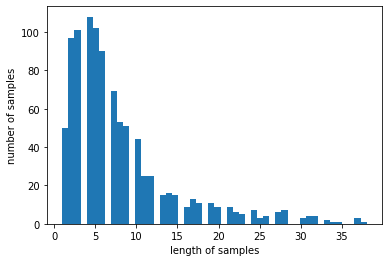

In [28]:
import matplotlib.pyplot as plt
max_len=max(len(l) for l in X)
print('리뷰의 최대 길이:',max_len)
print('리뷰의 평균 길이:',sum (map(len,X))/len(X))
plt.hist([len(s) for s in X], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show

In [29]:
#가로 길이를 맞추기 위해 패딩 처리
from tensorflow.keras.preprocessing.sequence import pad_sequences
X=pad_sequences(X, maxlen=max_len)

In [30]:
#학습용:검증용 8:2로 구분
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                test_size=0.2, stratify=y, random_state=0)

In [31]:
vocab_size

795

In [32]:
from tensorflow.keras.layers import Embedding,Dense,LSTM
from tensorflow.keras.models import Sequential

model=Sequential()
# Embedding(입력사이즈,출력사이즈)
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128)) #타임스텝을 128로 설정
model.add(Dense(1, activation='sigmoid',name='output'))
#출력층
model.compile(optimizer='rmsprop',loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         79500     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 196,877
Trainable params: 196,877
Non-trainable params: 0
_________________________________________________________________


In [33]:
#학습과정
hist=model.fit(X_train,y_train[:X_train.shape[0]],epochs=50,
              batch_size=60, validation_split=0.2)

Train on 627 samples, validate on 157 samples
Epoch 1/50
627/627 [==============================] - 2s 3ms/sample - loss: 0.6907 - accuracy: 0.5534 - val_loss: 0.6843 - val_accuracy: 0.6115
Epoch 2/50
627/627 [==============================] - 0s 706us/sample - loss: 0.6334 - accuracy: 0.7257 - val_loss: 0.6482 - val_accuracy: 0.6497
Epoch 3/50
627/627 [==============================] - 0s 638us/sample - loss: 0.5403 - accuracy: 0.7879 - val_loss: 0.6640 - val_accuracy: 0.6624
Epoch 4/50
627/627 [==============================] - 0s 595us/sample - loss: 0.4510 - accuracy: 0.8788 - val_loss: 0.6460 - val_accuracy: 0.6815
Epoch 5/50
627/627 [==============================] - 0s 561us/sample - loss: 0.5451 - accuracy: 0.8660 - val_loss: 0.6196 - val_accuracy: 0.6624
Epoch 6/50
627/627 [==============================] - 0s 566us/sample - loss: 0.3209 - accuracy: 0.8995 - val_loss: 0.6618 - val_accuracy: 0.6624
Epoch 7/50
627/627 [==============================] - 0s 643us/sample - loss: 0.

In [34]:
#모형의 성능 평가
score=model.evaluate(X_test,y_test[:X_test.shape[0]],verbose=0)
print(score)

[2.305859144853086, 0.6989796]


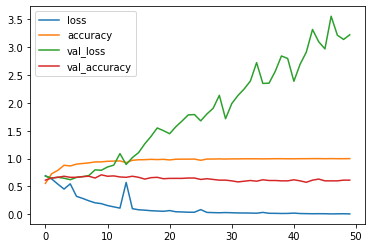

In [35]:
#학습과정 그래프
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','accuracy','val_loss','val_accuracy'])
plt.show()


In [38]:
n=100
print(X_test[n])
a=model.predict(X_test[n].reshape(1,len(X_test[n])))
print(a) #긍정리뷰

n=150
print(X_test[n])
a=model.predict(X_test[n].reshape(1,len(X_test[n])))
print(a) #부정리뷰

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  35
 604   5]
[[0.96720815]]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 59 59 59 59 59 59 59 59]
[[5.571596e-12]]
